# Vehicle&Lanes_Detection&Tracking_Pipeline_Using_SVM_OpenCV

This pipeline implements the following functionalities/Steps:

* Camera Calibration.
* Perspective Transformation.
* Lanes Detection Using Sliding Window Technique.
* HOG Features Extraction.
* SVM Classifier Training on GTI & KITTI Data sets.
* Vehicles Detection & Tracking Using Slididng Windows & Heatmaps Technique.



In [1]:
## Importing Necessary libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
%matplotlib inline

import numpy as np
import cv2
from glob import glob
import PIL.Image
from IPython.display import Image, HTML, display
import matplotlib.colors
import colorsys
import pickle

import os
from os import listdir
from os.path import isfile, join

## Importing the necessary libs

import numpy as np
import pandas as pd
import csv
import cv2
import sklearn
import random, pylab

from sklearn import preprocessing
from sklearn.utils import shuffle
from skimage import exposure
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Lanes Detection APIs

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xleftfitted = [] 
        self.recent_xrightfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx_left = []
        self.bestx_right = []
        #polynomial coefficients and the averaged fits over the last n iterations
        self.rightfit = [] 
        self.leftfit = []
        
        self.best_rightfit = [] 
        self.best_leftfit = []
        
        #left & right lane inds
        self.left_lane_inds = []
        self.right_lane_inds = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 500 ##Initial value
        #distance in meters of vehicle center from the line
        self.line_base_pos = [] 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
        #smoothing n iteration counter
        self.iter_cntr = 0
        #Sanity check failure counter
        self.failed = 0

In [3]:
## Camera Calibration API
##Images 1,4,5 are neglected as they don't conform to the mesh grid (9,6) size

def camera_calib(calib_img_list):
    chess_length = 9
    chess_width = 6
    coordinates = 3
    
    objpoints = []
    imgpoints = []
    calib_output_list = []
    
    objp = np.zeros((chess_length * chess_width, coordinates), np.float32)
    objp[:,:2] = np.mgrid[0:chess_length, 0:chess_width].T.reshape(-1, 2)
    
    ## Aggregate imgpoints & objpoints from all the calibration images
    for i in range(len(calib_img_list)):
        
        gray = cv2.cvtColor(calib_img_list[i], cv2.COLOR_RGB2GRAY)   
        ret, corners = cv2.findChessboardCorners(gray, (chess_length,chess_width), None)
    
        #If corners are available add object & corner points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)    
            calib_output_list.append(cv2.drawChessboardCorners(calib_img_list[i], (chess_length,chess_width), corners, ret))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return  calib_output_list, mtx, dist

In [4]:
##Import calibration images
calib_img_list = glob('camera_cal/*.jpg')
calib_img_list = list(map(mpimg.imread, calib_img_list))

In [5]:
calib_output_list, mtx, dist = camera_calib(calib_img_list)

In [6]:
##Images Undistortion API

def undistort(img, mtx=mtx, dist=dist):
    
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_img

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=None):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    
    # Return the result
    return binary_output

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [9]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
##Create different combinatons of gradient magnitude and direction filters
def grad_combine(img,ksize=3):
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

In [11]:
# Define a function that thresholds the S-channel & L-channel of HLS color space
def hls_select(img, thresh_s=None, thresh_l=None):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[((s_channel > thresh_s[0]) & (s_channel <= thresh_s[1])) & ((l_channel > thresh_l[0]) & (l_channel <= thresh_l[1]))] = 1
    
    #As you can see I've tried many combinations till reached to a satisfactory output
    #binary_output[((l_channel > thresh_l[0]) & (l_channel <= thresh_l[1]))] = 1
    #binary_output[((s_channel > thresh_s[0]) & (s_channel <= thresh_s[1]))] = 1
    
    return binary_output

In [12]:
# Define a function that thresholds the S-channel & L-channel of HLS color space
def hls_select(img, thresh_s=None, thresh_l=None):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[((s_channel > thresh_s[0]) & (s_channel <= thresh_s[1])) & ((l_channel > thresh_l[0]) & (l_channel <= thresh_l[1]))] = 1
    
    #As you can see I've tried many combinations till reached to a satisfactory output
    #binary_output[((l_channel > thresh_l[0]) & (l_channel <= thresh_l[1]))] = 1
    #binary_output[((s_channel > thresh_s[0]) & (s_channel <= thresh_s[1]))] = 1
    
    return binary_output

In [13]:
## Define a function that combines gradient and color space filters
def grad_hls_combine(img, ksize=3):
    
    sl_binary = hls_select(img, thresh_s=(100, 255), thresh_l=(100, 255))
    sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 255))
    grad_comb = grad_combine(img,ksize=ksize)
    
    #As you can see I've tried many combinations of color channels and gradients and gradient thresholds till reached
    #a satisfactory output 
    binary_output = np.zeros_like(sl_binary)
    binary_output[(sl_binary == 1) | (sx_binary == 1)] = 1
    #binary_output[(sl_binary == 1)] = 1
    return binary_output

In [14]:
## Bird's Eye Perspective Transformation API
def persp_tarnsform(img):
    
    img_size = (img.shape[1], img.shape[0])

## Also, here I've tried many values for src & dist points and I chose to keep all of them for future enhancements in this 
#pipeline.

##These values are extracted manually from the test images by trial and error methodology 
    bottom_left_src = [210, 720]
    bottom_right_src = [1110, 720]
    top_left_src = [565, 470]
    top_right_src = [720, 470]
    
##These values are used as per some recommendations on Udacity forums     
    bottom_left = [320,720] 
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]
    
    #src = np.float32([bottom_left_src,bottom_right_src,top_right_src,top_left_src])
    #dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    ################
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])

    
    ## Define the region of interest
    #src = np.float32([[190, 700], [1110, 700], [720, 470], [570, 470]])
    #
    #bottom_left = src[0][0]+100, src[0][1]
    #bottom_right = src[1][0]-200, src[1][1]
    #top_left = src[3][0]-250, 1
    #top_right = src[2][0]+200, 1
    #dst = np.float32([bottom_left, bottom_right, top_right, top_left])
    ################################
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    ## This is one of the methods I've tried to eliminate the noise on the image sides but it's not used for now.
    ## Neglect any data on the outer shelter of the image (shelter thickness = 50 pixels) as this segments are more likely to 
    ## cause unwanted noise
    #binary_warped[0:50, :] = 0
    #binary_warped[:, 0:50] = 0
    #binary_warped[(img.shape[0] - 50):img.shape[0], :] = 0
    #binary_warped[:, (img.shape[1] - 50):img.shape[1]] = 0
    
    return binary_warped , Minv

In [15]:
## This API handles all the preprocessing of each frame
def frame_processor_lanes(img, ksize=3):
    
    undistorted_img = undistort(img)
    grad_hls_combine_img = grad_hls_combine(undistorted_img, ksize=ksize)
    bird_eye_img, Minv = persp_tarnsform(grad_hls_combine_img)
    
    return bird_eye_img , undistorted_img, Minv #Inverse camera matrix

In [16]:
## this API applies the sliding window search approach for detecting the lane lines without dependency on a previous fitted polynomials
def blind_slide_window_detector(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ##No need for them for now
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds

In [17]:
def slide_window_detector(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    ############################################
    ##############################################
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    ##No need for them for now
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds

In [18]:
# this API fills/highlight the region of interest depending on the sliding window search results
def lane_highlight(binary_warped, undistorted_img, ploty, left_x, right_x, Minv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
                    
    return result

In [19]:
## this API Determines the lane curvature & shifting from the lane center of each frame
def lane_curvature(lane_img, ploty, leftx, rightx):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ## Identify the x and y positions of all nonzero pixels in the image
    #nonzero = lane_img.nonzero()
    #nonzeroy = np.array(nonzero[0])
    #nonzerox = np.array(nonzero[1])
    ## Again, extract left and right line pixel positions
    #leftx = nonzerox[left_lane_inds]
    #lefty = nonzeroy[left_lane_inds] 
    #rightx = nonzerox[right_lane_inds]
    #righty = nonzeroy[right_lane_inds]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters    
    
    current_lane_curvature = (left_curverad + right_curverad) / 2
    
    ## Determining the shifting of the vehicle center from the lane center line
    ##Note that I've assumed here that the image center indicates the vehicle center (Assumed that camera is centered in the
    ##vehicle front)
    camera_img_center = np.uint16(lane_img.shape[1]/2)
    #print(camera_img_center)
    left_spacing = []
    right_spacing = []
    shif_spac = []
    for i in range(10):
        rand_index = random.randint(0, (len(leftx)-1))
        left_spacing.append(camera_img_center - leftx[rand_index])
        right_spacing.append(rightx[rand_index] - camera_img_center)
        
    shift_space = [x-y for (x,y) in zip(left_spacing, right_spacing)]
    
    #print(shift_space)    
    veh_shift_m = (sum(shift_space)/10) * xm_per_pix
    #print(veh_shift_m)
    if veh_shift_m > 0:
        cv2.putText(lane_img, "Vehicle is %.3f meters left of the lane center" % abs(veh_shift_m), (250, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 4)
    elif veh_shift_m < 0:
        cv2.putText(lane_img, "Vehicle is %.3f meters right of the lane center" % abs(veh_shift_m), (250, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 4)
    else:
        cv2.putText(lane_img, "Vehicle is centered on the lane", (250, 300), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 4)
       
    cv2.putText(lane_img, "Current Radius of Curvature = %.2f Meters" % current_lane_curvature, (250, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 4)
    #plt.imshow(lane_img)
    return current_lane_curvature, lane_img


In [20]:
## This API applies three helpful sanity chck on each frame results: 
## 1- Assuring that there's not a big "Not logical" change between the current and prev lane curvature with an allowable margin of
# change = 50 m.
# 2- Assuring that the lane lines spacing is with acceptable deviation from the standard spacing: +/- 1m.
# 3- Assuring that the lane lines slopes are roughly within range by determing the slopes of random sets of left & right line 
# points and getting their average.

def sanity_checks(current_lane_curvature, prev_lane_curvature, left_fit, right_fit, left_x, right_x):
    
    ##1- Curvature check
    
    if np.float32(abs(np.float32(current_lane_curvature) - prev_lane_curvature)) < 50:
        curvature_check = True
    else:   
        curvature_check = False
        
        
    ##2- Lane lines spacing
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_width_pxl = []
    min_lane_width = 3.7
    
    for i in range(10):
        rand_index = random.randint(0, (len(left_x)-1))
        lane_width_pxl.append(right_x[rand_index] - left_x[rand_index])
    
    avrg_width_m = (sum(lane_width_pxl)/10) * xm_per_pix
    
    if  ((min_lane_width - 1) < avrg_width_m < (min_lane_width + 1)):
        lanes_spacing = True
    else:
        lanes_spacing = False
    
    
    ##3- Lane lines parallelism
    
    left_slope_list = []
    right_slope_list = []
    for i in range(10):
        rand_index = random.randint(0, (len(left_x)-1))
        left_slope_list.append(2*left_fit[0]*left_x[rand_index] + left_fit[1])
        right_slope_list.append(2*right_fit[0]*right_x[rand_index] + right_fit[1])
    
    left_slope = sum(left_slope_list)/len(left_slope_list)
    right_slope = sum(right_slope_list)/len(right_slope_list)
    
    if np.float32(abs(np.float32(left_slope - right_slope))) < 0.5:
        slope_check = True
    else:
        slope_check = False
        
    return curvature_check, lanes_spacing, slope_check

In [21]:
## This API should perfom the lane detection without performing the smoothing process and this is what I finally used as I 
#didn't experienced a noticable enhancement using the smoothing step.

def lane_detect(img):
        
    ## Camera is now calibrated and the frame is ready for the preprocessing 
    processed_frame, undistorted_img, Minv = frame_processor_lanes(img)

    if line.detected is False:  
        
        result_imgBlind, plotyBlind, left_fitBlind, right_fitBlind, left_xBlind, right_xBlind, line.left_lane_inds, line.right_lane_inds = blind_slide_window_detector(processed_frame)    
        
        line.bestx_left = left_xBlind
        line.bestx_right = right_xBlind
                
        line.best_leftfit = left_fitBlind
        line.best_rightfit = right_fitBlind
        
        line.ally = plotyBlind
        
    else:
        result_img, ploty, left_fit, right_fit, left_x, right_x, line.left_lane_inds, line.right_lane_inds = slide_window_detector(processed_frame, np.asarray(line.best_leftfit), np.asarray(line.best_rightfit))        

        line.bestx_left = left_x
        line.bestx_right = right_x
                
        line.best_leftfit = left_fit
        line.best_rightfit = right_fit
        
        line.ally = ploty    
    
           
    ## Updating RoC & Lane Highlighting
    prev_lane_curvature = line.radius_of_curvature
    lane_img = lane_highlight(processed_frame, undistorted_img, line.ally,  np.asarray(line.bestx_left), np.asarray(line.bestx_right), Minv)
    current_lane_curvature, lane_img = lane_curvature(lane_img, line.ally, np.asarray(line.bestx_left), np.asarray(line.bestx_right))
    line.radius_of_curvature = current_lane_curvature
    
    ##Sanity checks for the next frame processing
    curvature_check, lanes_spacing, slope_check = sanity_checks(current_lane_curvature, prev_lane_curvature, np.asarray(line.best_leftfit), np.asarray(line.best_rightfit), line.bestx_left, line.bestx_right)
    
    ## Deciding whether to start the window blind search again or not
    if (curvature_check & (lanes_spacing | slope_check)):
        
        line.detected = True
    else:
        line.detected = False
    
    return lane_img

## Vehicles Detecion & Tracking APIs

### SVM Data Loading & Exploring

In [22]:
## Loading GTI & KITTI Data sets
veh_GTI_Far_data = glob('../VehiclesData/vehicles/GTI_Far/*.png')
veh_GTI_Left_data = glob('../VehiclesData/vehicles/GTI_Left/*.png')
veh_GTI_MiddleClose_data = glob('../VehiclesData/vehicles/GTI_MiddleClose/*.png')
veh_GTI_Right_data = glob('../VehiclesData/vehicles/GTI_Right/*.png')
veh_KITTI_extracted_data = glob('../VehiclesData/vehicles/KITTI_extracted/*.png')


nonveh_GTI_data = glob('../VehiclesData/non-vehicles/GTI/*.png')
nonveh_extra_data = glob('../VehiclesData/non-vehicles/Extras/*.png')

veh_data_list = []
nonveh_data_list = []

veh_data_list.extend(veh_GTI_Far_data + veh_GTI_Left_data + veh_GTI_MiddleClose_data + veh_GTI_Right_data \
                     + veh_KITTI_extracted_data)

nonveh_data_list.extend(nonveh_GTI_data + nonveh_extra_data)

veh_data_labels = [1 for x in veh_data_list]
nonveh_data_labels = [0 for x in nonveh_data_list]

# Define a labels vector based on features lists
labels = np.hstack((veh_data_labels, 
              nonveh_data_labels))

test_samples = []
test_labels = []

In [23]:
## This API takes images data set as images or files and their corresponding labels and can easily display random samples of 
## this data.

def display_DataSample(dataSet, labels, color_space='RGB'):
    fig = plt.figure(figsize=(20, 20))
    for i in range(9): 
        index = random.randint(0, len(dataSet))
        image = mpimg.imread(dataSet[index]).squeeze()
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: None
    
        sub = fig.add_subplot(1, 9, i+1)
        sub.imshow(image, interpolation='nearest')
        
        if labels[index] == 0:
            plt.title("Non Vehicle")
        else:
            plt.title("Vehicle")
    return

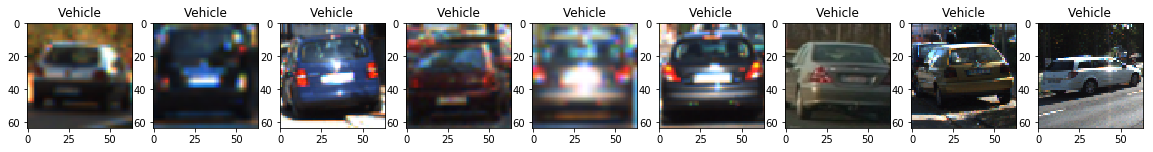

In [24]:
display_DataSample(veh_data_list, veh_data_labels, 'RGB')

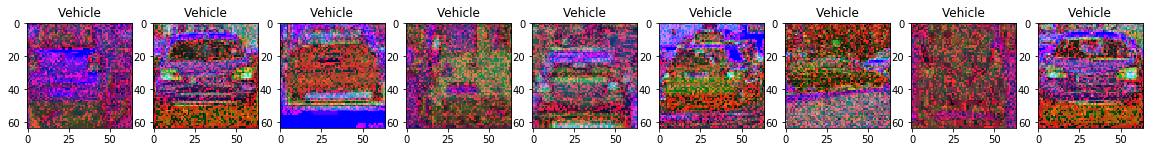

In [25]:
display_DataSample(veh_data_list, veh_data_labels, 'HSV')

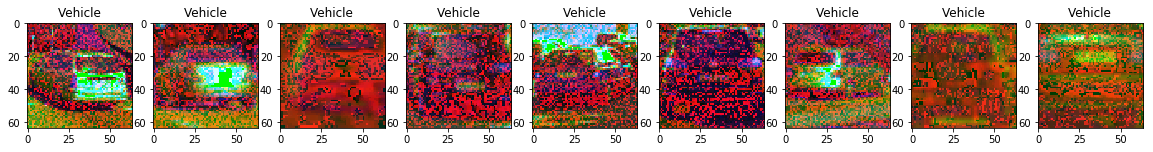

In [26]:
display_DataSample(veh_data_list, veh_data_labels, 'HLS')

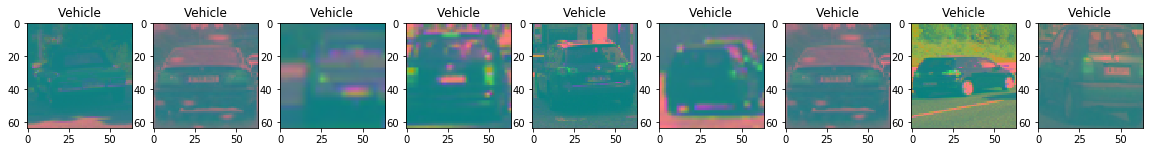

In [27]:
display_DataSample(veh_data_list, veh_data_labels, 'YUV')

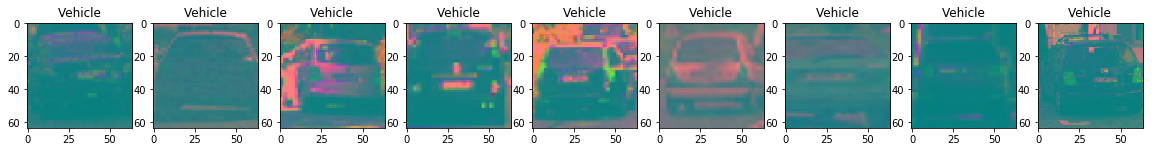

In [28]:
display_DataSample(veh_data_list, veh_data_labels, 'YCrCb')

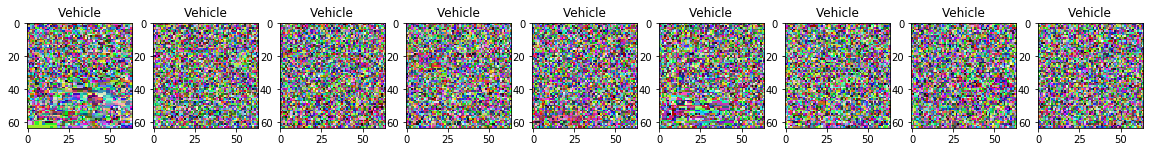

In [29]:
display_DataSample(veh_data_list, veh_data_labels, 'LUV')

# Training Features Extraction, Combination & Scaling

In [30]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features #rhist, ghist, bhist, bin_centers

In [31]:
# Define a function to bin spatial image features (raw pixels values)  
def bin_spatial(img, size):
        
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))

In [32]:
# Define a function to return HOG features and visualization
# HOG features could be extracted under tuning of different parameters  1- pix_per_cell 2- cell_per_block 3- No. of HOG orientations
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        

In [33]:
# This API is used to extract features from the training data 
# It's implemented to extract three features by default from each image 1- Raw Pixel Values after selectable spatial binning.
# 2- Histogram of Pixel Values. 3- HOG features of each channel under specific selectable parameters.
# This API could be modified easily to make each feature extarction is selectable.
# This API receives the color_space as input in order to convert the image to the selected color space before 
# starting extract any features. Also spatial size and HOG tuning parameters and we can control the return to be either the 
# feature vector or the feature image or both.
def features_extract(img, color_space, size, orient, pix_per_cell, cell_per_block, vis=False, 
                     feature_vec=False):
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    else: feature_image = np.copy(img) 
        
    rawPixel_featureVector = bin_spatial(feature_image, size)
    hist_features = color_hist(feature_image, nbins=32, bins_range=(0, 256))
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    hog_features = np.hstack((hog1.ravel(), hog2.ravel(), hog3.ravel()))
    
    feature_vec = np.hstack((rawPixel_featureVector, hist_features, hog_features))
    return feature_vec 

In [34]:
## This API goes through the loaded data and extract the three mentioned feature from each image and append all of these features
# into single feature vector for the vehicle images and another for nons.
def train_featExtract(color_space, size, orient, pix_per_cell, cell_per_block):
    veh_featVec = []
    nonveh_featVec = []
    
    for file in veh_data_list:
        image = mpimg.imread(file)
        veh_featVec.append(features_extract(image, color_space, size, orient, pix_per_cell, cell_per_block))
        
    for file in nonveh_data_list:
        image = mpimg.imread(file)
        nonveh_featVec.append(features_extract(image, color_space, size, orient, pix_per_cell, cell_per_block))
        
    return veh_featVec, nonveh_featVec

In [35]:
# This API stacks both of the extracted feature vectors and scales them to overcome the different scales due to the variety 
# of the collected features.
def trainfeat_scaler(veh_featVec, nonveh_featVec):
    if len(veh_featVec) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((veh_featVec, nonveh_featVec)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
    return scaled_X, X_scaler

# SVM Classifier Training

In [36]:
# This API shall uses the splitted training and test data to train a linear SVM model and test this on the dedicated test data 
# and printing out the test accuracy.
def classifier_train(X_train, y_train, X_test, y_test):
    
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc

## Vehicle Detection APIs

In [37]:
# Define a class to save the heatmap labels and bbox centroids in order to smooth them over "smooth" frames 
class HeatMap():
    def __init__(self, smooth):
        #labels container
        self.labels = [None] * smooth  
        self.frames_cntr = 0
        # Bounding Boxes Centroid container
        self.centroids = []
        self.centroids_cntr = 0
        self.draw_cntr = 0
        

In [50]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## This API receives class obj to save the centroids over last n detections and the heat map labels of each frame and 
# the bbox merging threshould as inputs
def draw_labeled_bboxes(img, labels, heatmap_obj):
    
    centroids = []
    x_left = []
    x_right = []
    y_top = []
    y_bottom = []

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        # Here's my approach to smooth the bbox before drawing through calculating its centroid and then smooth(average) 
        # this centroid over the last n detections to make the detection more stable (Decrease the fluctuations).
        if len(heatmap_obj.centroids) != 10: 
            box_centroid = ((((np.max(nonzerox) - np.min(nonzerox)) / 2) + np.min(nonzerox)), 
                            (((np.max(nonzeroy) - np.min(nonzeroy)) / 2) + np.min(nonzeroy)))
            heatmap_obj.centroids.append(box_centroid)
            heatmap_obj.centroids_cntr +=1
            
            if len(heatmap_obj.centroids) != 0:
                smoothed_centroid = np.sum(heatmap_obj.centroids, 0) // len(heatmap_obj.centroids)
        else:
            box_centroid = ((((np.max(nonzerox) - np.min(nonzerox)) / 2) + np.min(nonzerox)), 
                            (((np.max(nonzeroy) - np.min(nonzeroy)) / 2) + np.min(nonzeroy)))
            heatmap_obj.centroids.append(box_centroid)
            smoothed_centroid = np.sum(heatmap_obj.centroids[-11:-1], 0) // len(heatmap_obj.centroids[-11:-1])
            
        #Define the expected ranges of vehicle appearance in order to scale the bbox accordingly and reject any outlier
        if  400 >= smoothed_centroid[1] > 350:
            x_left.append(np.int(1.05 * np.min(nonzerox)))
            x_right.append(np.int(0.95 * np.max(nonzerox)))
            y_top.append(np.int(1.05 * np.min(nonzeroy)))
            y_bottom.append(np.int(0.95 * np.max(nonzeroy)))
            
        elif  450 >= smoothed_centroid[1] > 400:
            x_left.append(np.int(1 * np.min(nonzerox)))
            x_right.append(np.int(1 * np.max(nonzerox)))
            y_top.append(np.int(1 * np.min(nonzeroy)))
            y_bottom.append(np.int(1 * np.max(nonzeroy)))
            
        elif 500 >= smoothed_centroid[1] > 450:
            x_left.append(np.int(0.95 * np.min(nonzerox)))
            x_right.append(np.int(1.05 * np.max(nonzerox)))
            y_top.append(np.int(0.95 * np.min(nonzeroy)))
            y_bottom.append(np.int(1.05 * np.max(nonzeroy)))
            
        elif 550 >= smoothed_centroid[1] > 500:
            x_left.append(np.int(0.9 * np.min(nonzerox)))
            x_right.append(np.int(1.1 * np.max(nonzerox)))
            y_top.append(np.int(0.9 * np.min(nonzeroy)))
            y_bottom.append(np.int(1.1 * np.max(nonzeroy)))
            
        elif 600 >= smoothed_centroid[1] > 550:
            x_left.append(np.int(0.85 * np.min(nonzerox)))
            x_right.append(np.int(1.15 * np.max(nonzerox)))
            y_top.append(np.int(0.85 * np.min(nonzeroy)))
            y_bottom.append(np.int(1.15 * np.max(nonzeroy)))
            
        else:
            x_left.append(np.min(nonzerox))
            x_right.append(np.max(nonzerox))
            y_top.append(np.min(nonzeroy))
            y_bottom.append(np.max(nonzeroy))
            
        centroids.append(smoothed_centroid)
        
        ## Extra false positive filter out
        ## Define all the centroids lie in this regions as rejected detections to filter out false positive detections from the
        ## opposite direction, these ranges got after analyzing multiple test images end excluding the range of upcoming road.
        if ((0 < x_left[-1] < 650) or (0 < x_right[-1] < 650)) and ((350 < y_top[-1] < 720) or (350 < y_bottom[-1] < 720)):
            None
        else:
            
            bbox = ((x_left[-1], y_top[-1]),(x_right[-1], y_bottom[-1]))
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
            
    ## I tried through the following lines of code to implement bbox merging of narrow boxes but ended up with unmature 
    # output so stopped my progress on it for now
    
    ### Avoid drawing on empty frames    
    #if labels[1] != 0:   
    #    ## Merging the overlapped boxes    
    #    if len(centroids) > 1:
    #        for i in range (len(centroids)):
    #            if (((abs(centroids[i][0] - centroids[i+1][0])) < merge_thresh) and 
    #            ((abs(centroids[i][1] - centroids[i+1][1])) < merge_thresh)): 
    #                
    #                print(centroids[-1][0])
    #                print(centroids[-2][0])
    #                print(centroids[-1][1])
    #                print(centroids[-2][1])
    #            bbox = ((min(x_left[i],x_left[i+1]), min(y_top[i],y_top[i+1])), 
    #                    (max(x_right[i],x_right[i+1]), max(y_bottom[i],y_bottom[i+1])))
    #            # Draw the box on the image
    #            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    #            
    #        else:
    #            for i in range(len(x_left)):
    #                bbox = ((x_left[i], y_top[i]),(x_right[i], y_bottom[i]))
    #                # Draw the box on the image
    #                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    #    else:
    #        bbox = ((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox), np.max(nonzeroy)))
    #        # Draw the box on the image
    #        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        
        
    # Return the draw image
    return img

In [51]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# This API extracts the selected features from each image and applies the window search technique and then applies heatmap 
# threshoulding and then could selectively returns the heatmap labels and call the draw_labeled_bboxes() API or display the 
# heatmap and output image instead.
# It receives the selected color space, (ystart, ystop) as inputs define the ROI of the sliding windows, the trained SVM model and the training features
# scaler, HOG tuning parameters, heatmap threshoulds and heatmap class obj to save the heatmaps over n frames and no of frames
# smooth over and finally the selected window scales list.
def find_cars(img, color_space, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins, heatmap_thresh, smoothedheatmap_thresh, heatmap_obj, smooth, visulaize):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
                
    else: ctrans_tosearch = np.copy(img_tosearch)  

    bbox_list = []
    
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            #ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255
            
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        
        
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
                hog_features = np.hstack((hog_feat1.ravel(), hog_feat2.ravel(), hog_feat3.ravel()))
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
    
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                # Scale features and make a prediction
                feature_vec = np.hstack((spatial_features, hist_features, hog_features)).astype(np.float64)
                
                # Apply the scaler to feature_vec
                test_features = X_scaler.transform(feature_vec.reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                
                if test_prediction == 1:
                
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    
                    ## Append the new points to the bbox list
                    bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    ## Creating heat map using the detected bbox 
    heat_map = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    heat_map = add_heat(heat_map, bbox_list)
    
    if visulaize is True:
        fig = plt.figure(figsize=(20, 20))
        
        sub = fig.add_subplot(141)
        plt.title('Frame Heat Map')
        sub.imshow(heat_map)
        
    ## Applying a resonable threshould to this heatmap
    heat_map = apply_threshold(heat_map, threshold=heatmap_thresh)
    
    if visulaize is True:
        
        sub = fig.add_subplot(142)
        plt.title('Threshoulded Heat Map')
        sub.imshow(heat_map)
        
    # Smooth the resulted heatmap over n frames 
    heat_map_smoothed = np.zeros_like(heat_map).astype(np.float)
    
    if heatmap_obj.frames_cntr < smooth:
        heatmap_obj.labels[heatmap_obj.frames_cntr] = heat_map
        if heatmap_obj.frames_cntr != 0 :
            for i in range(len(heatmap_obj.labels)):
                if heatmap_obj.labels[i] != None:
                    heat_map_smoothed = np.add(heat_map_smoothed, heatmap_obj.labels[i])
                    
        ## Applying secondary thresh to the smoothed heatmap , this found to help filtering out many false positives
        heat_map_smoothed = apply_threshold(heat_map_smoothed, threshold=smoothedheatmap_thresh)

        heatmap_obj.frames_cntr +=1
    
    elif heatmap_obj.frames_cntr >= smooth:
        heatmap_obj.frames_cntr = 0
        heatmap_obj.labels[heatmap_obj.frames_cntr] = heat_map
        heat_map_smoothed = np.sum(heatmap_obj.labels, 0)
        ## Applying secondary thresh to the smoothed heatmap , this found to help filtering out many false positives
        heat_map_smoothed = apply_threshold(heat_map_smoothed, threshold=smoothedheatmap_thresh)
        heatmap_obj.frames_cntr +=1
        
    ## For not visulaize option the smoothed labels should only be returned.
    labels = label(heat_map_smoothed)  
    
    if visulaize is True:
        
        sub = fig.add_subplot(143)
        plt.title('Smoothed Heat Map')
        sub.imshow(heat_map_smoothed)
        
        # Draw the smoothed labels
        out_img = draw_labeled_bboxes(draw_img, labels, heatmap_obj)  
        
        sub = fig.add_subplot(144)
        plt.title('Final Detections Frame')
        sub.imshow(out_img)
        
        
    
    return labels

# Different Approaches Used To Address The Vehicle Detection Problem

I've used different features and parameter tuning combinations to figure out which combination will do the best on a set of well selected test images and the result was as follows:

### First Combination

The Parameters here are as follows:
* Color space = LUV
* Hog Orientations = 9
* Spatial Size = (16, 16)
* Cells Per Block = 2
* Pixels Per Block = 8
* Histogram Bins = 32
* Window Scale = 1, 1.5

In [41]:
#### Evaluating parameters for this trial

color_space='LUV'
spatial_size=(16, 16)
orient=9
pix_per_cell=8
cell_per_block=2
ystart = 350
ystop = 656
hist_bins=32

## 1-  Extract & Scale Training Features
luv_veh_featVec = []
luv_nonveh_featVec = []
luv_veh_featVec, luv_nonveh_featVec = train_featExtract(color_space, spatial_size, orient, pix_per_cell, cell_per_block)

luv_scaled_feat = []
luv_scaled_feat, luv_X_scaler = trainfeat_scaler(luv_veh_featVec, luv_nonveh_featVec)

## 2- Test set split
rand_state = np.random.randint(0, 100)
luv_X_train, luv_X_test, luv_y_train, luv_y_test = train_test_split(luv_scaled_feat, labels, test_size=0.2, 
                                                                    random_state=rand_state)


## 2- Classifier Training

luv_svc_model = classifier_train(luv_X_train, luv_y_train, luv_X_test, luv_y_test)
## Save this model
with open("svc_pickle_luv.p", "wb") as file:
    pickle.dump(luv_svc_model, file)

Feature vector length: 6156
12.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9851


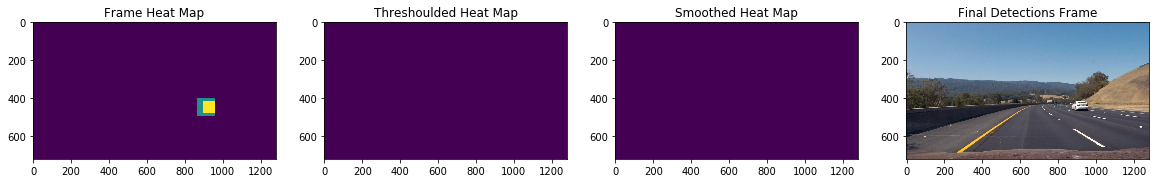

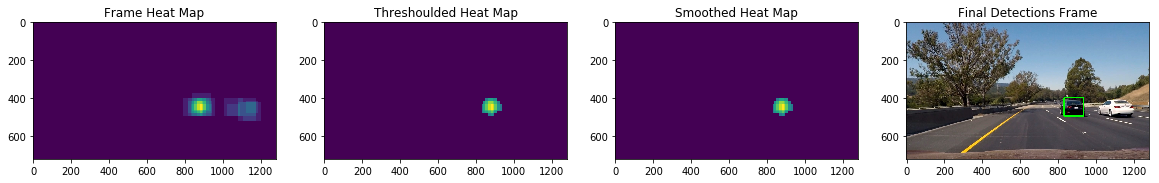

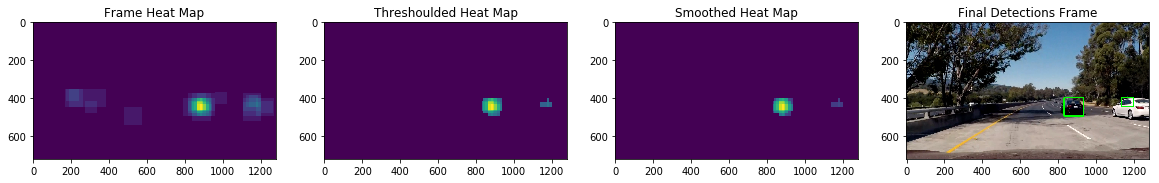

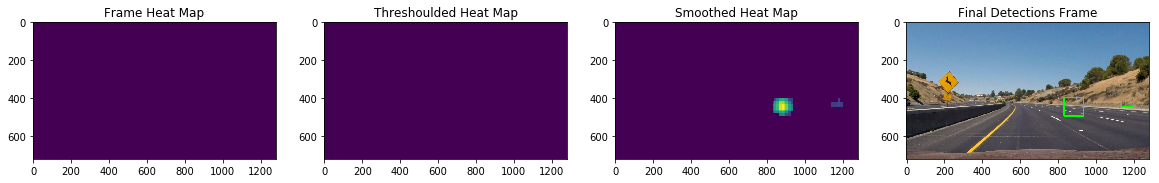

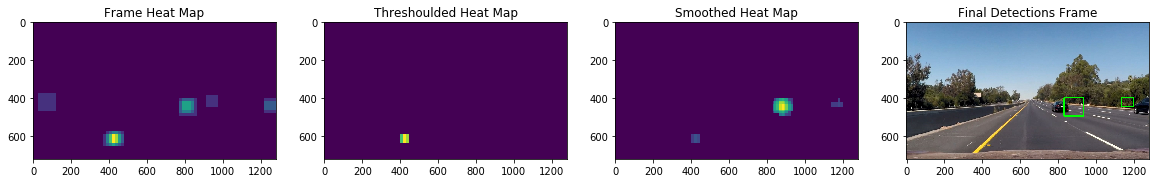

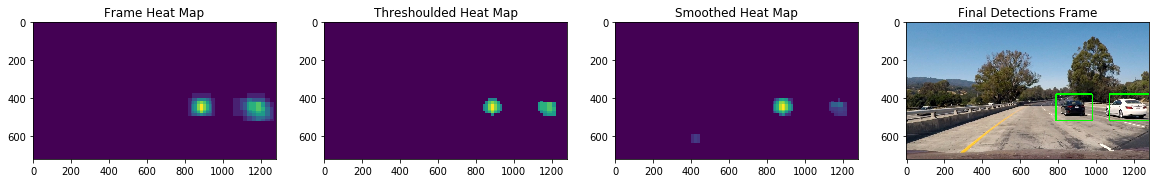

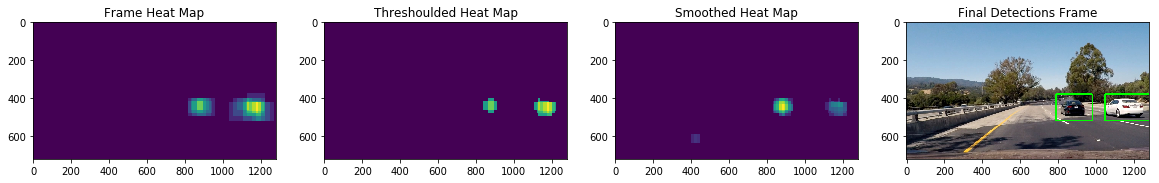

In [52]:
#### Evaluating parameters for this trial

color_space='LUV'
ystart=350
ystop=656
scales= [1, 1.5]
cell_per_block=2
spatial_size=(16,16)
hist_bins=32
pix_per_cell=8
orient=9
heatmap_thresh=4
smoothedheatmap_thresh = 3
smooth = 25
merge_thresh = 16
svc = luv_svc_model 
X_scaler = luv_X_scaler
vis = True
luv_inst = HeatMap(smooth)
## 3- Detect Vehicles

## Read in test images set
test_imgs_files = glob('test_images/*.jpg')
test_imgs_list = list(map(mpimg.imread, test_imgs_files))

fig = plt.figure(figsize=(12,15))

for i in range(len(test_imgs_list)):
    image = test_imgs_list[i]   
    out_img = find_cars(image, color_space, ystart, ystop, scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, luv_inst, smooth, vis)

### Second Combination

The Parameters here are as follows:
* Color Space = RGB
* Hog Orientations = 9
* Spatial Size = (16, 16)
* Cells Per Block = 2
* Pixels Per Block = 8
* Histogram Bins = 32
* Window Scale = 1, 1.5

In [53]:
#### Evaluating parameters for this trial

color_space='RGB'
spatial_size=(16, 16)
orient=9
pix_per_cell=8
cell_per_block=2
ystart = 350
ystop = 656
hist_bins=32


## 1-  Extract & Scale Training Features
veh_featVec = []
nonveh_featVec = []
veh_featVec, nonveh_featVec = train_featExtract(color_space, spatial_size, orient, pix_per_cell, cell_per_block)

scaled_feat = []
scaled_feat, rgb_X_scaler = trainfeat_scaler(veh_featVec, nonveh_featVec)

## 2- Test set split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_feat, labels, test_size=0.2, random_state=rand_state)


## 2- Classifier Training

rgb_svc_model = classifier_train(X_train, y_train, X_test, y_test)
## Save this model
with open("svc_pickle_rgb.p", "wb" ) as file:
    pickle.dump(rgb_svc_model, file)

Feature vector length: 6156
14.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9761


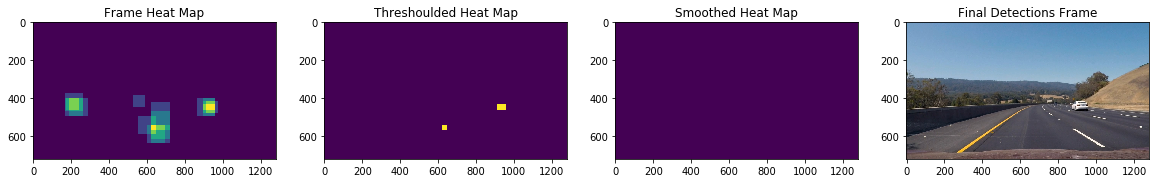

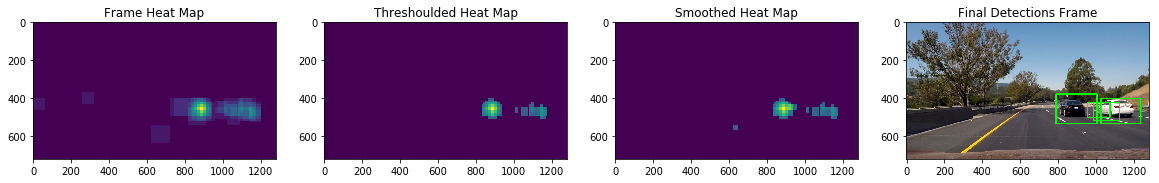

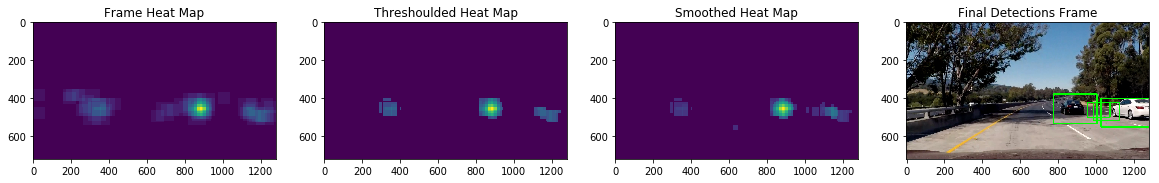

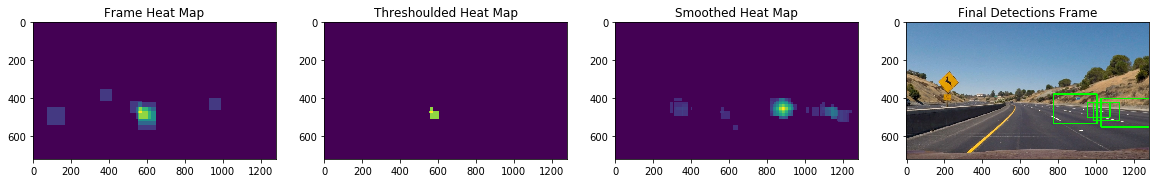

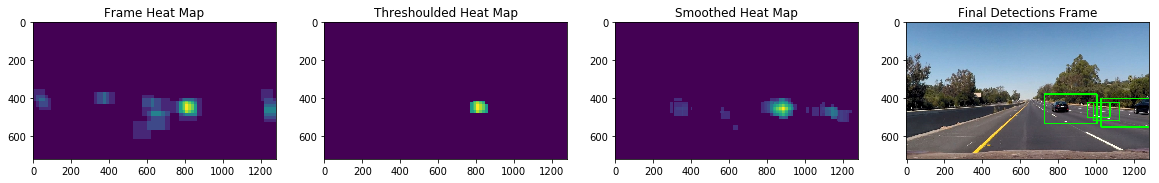

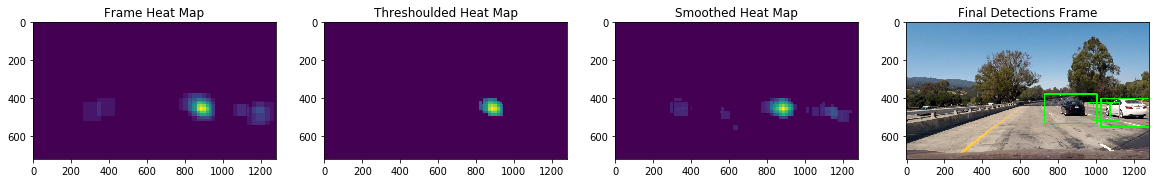

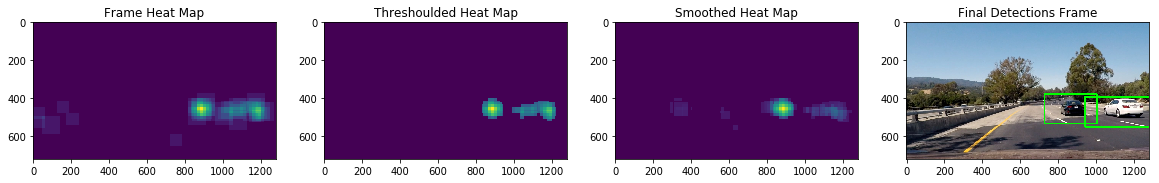

In [54]:
#### Evaluating parameters for this trial

color_space='RGB'
ystart=350
ystop=656
scales= [1, 1.5]
cell_per_block=2
spatial_size=(16,16)
hist_bins=32
pix_per_cell=8
orient=9
heatmap_thresh=4
smoothedheatmap_thresh = 3
smooth = 25
merge_thresh = 16
svc = rgb_svc_model 
X_scaler = rgb_X_scaler
vis = True
rgb_inst = HeatMap(smooth)

## 3- Detect Vehicles
## Read in test images set
test_imgs_files = glob('test_images/*.jpg')
test_imgs_list = list(map(mpimg.imread, test_imgs_files))

fig = plt.figure(figsize=(12,15))

for i in range(len(test_imgs_list)):
    image = test_imgs_list[i]   
    out_img = find_cars(image, color_space, ystart, ystop, scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, rgb_inst, smooth, vis)

### Third Combination

The Parameters here are as follows:
* Color Space = HLS
* Hog Orientations = 9
* Spatial Size = (16, 16)
* Cells Per Block = 2
* Pixels Per Block = 8
* Histogram Bins = 32
* Window Scale = 1, 1.5

In [55]:
#### Evaluating parameters for this trial

color_space='HLS'
spatial_size=(16, 16)
orient=9
pix_per_cell=8
cell_per_block=2
ystart = 350
ystop = 656
hist_bins=32
scale = 1.5

## 1-  Extract & Scale Training Features
veh_featVec = []
nonveh_featVec = []
veh_featVec, nonveh_featVec = train_featExtract(color_space, spatial_size, orient, pix_per_cell, cell_per_block)

scaled_feat = []
scaled_feat, hls_X_scaler = trainfeat_scaler(veh_featVec, nonveh_featVec)

## 2- Test set split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_feat, labels, test_size=0.2, random_state=rand_state)


## 2- Classifier Training

hls_svc_model = classifier_train(X_train, y_train, X_test, y_test)
## Save this model
with open("svc_pickle_hls.p", "wb" ) as file:
    pickle.dump(hls_svc_model, file)

Feature vector length: 6156
12.46 Seconds to train SVC...
Test Accuracy of SVC =  0.991


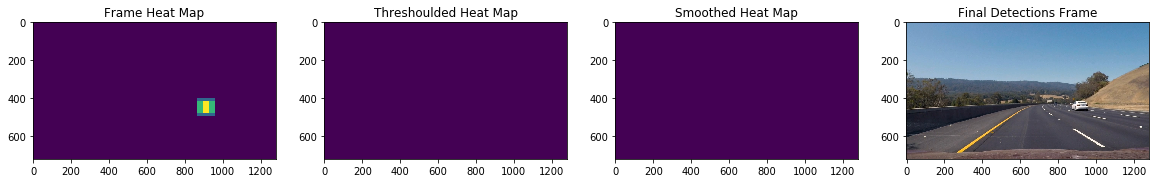

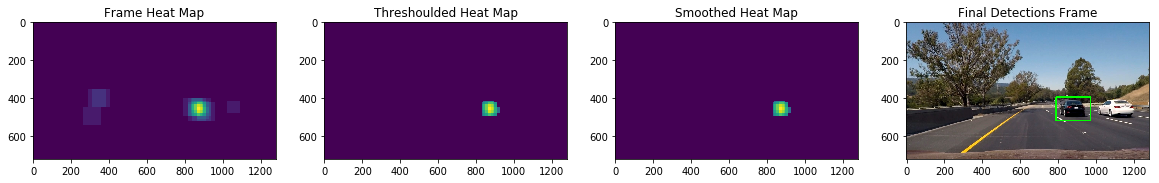

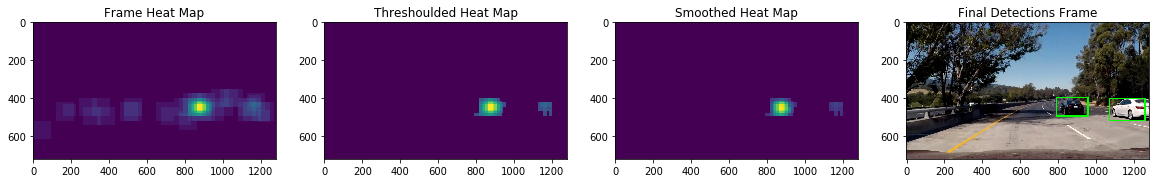

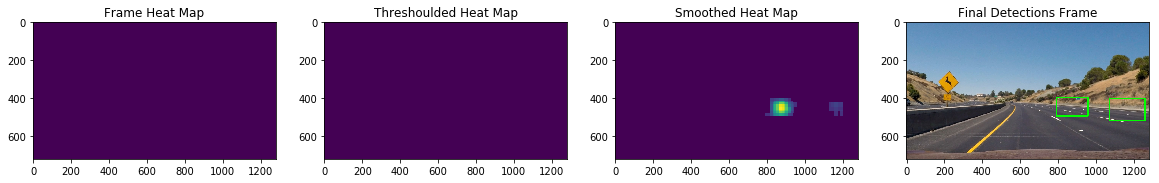

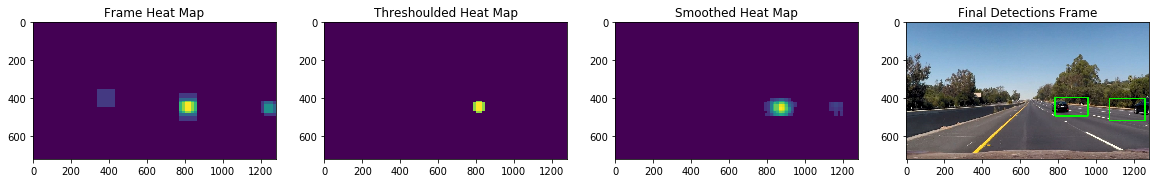

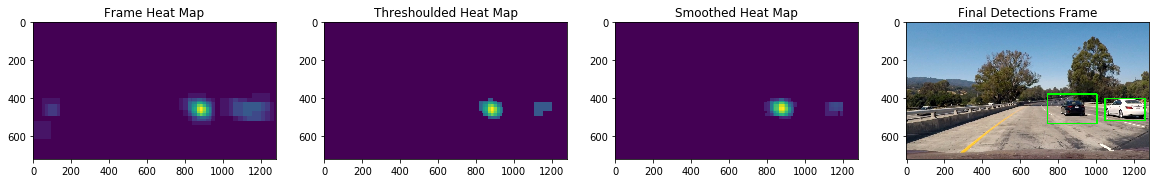

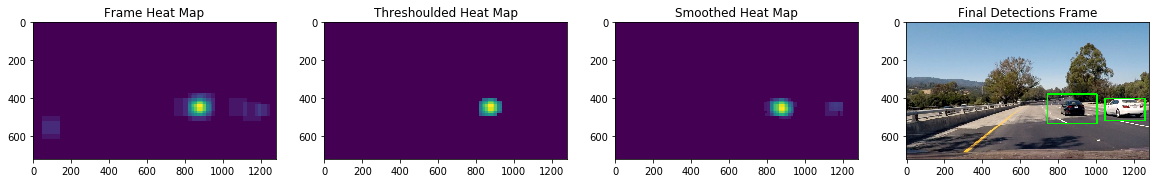

In [56]:
#### Evaluating parameters for this trial

color_space='HLS'
ystart=350
ystop=656
scales= [1, 1.5]
cell_per_block=2
spatial_size=(16,16)
hist_bins=32
pix_per_cell=8
orient=9
heatmap_thresh=4
smoothedheatmap_thresh = 3
smooth = 25
merge_thresh = 16
svc = hls_svc_model 
X_scaler = hls_X_scaler
vis = True
hls_inst = HeatMap(smooth)

## 3- Detect Vehicles
## Read in test images set
test_imgs_files = glob('test_images/*.jpg')
test_imgs_list = list(map(mpimg.imread, test_imgs_files))

fig = plt.figure(figsize=(12,15))

for i in range(len(test_imgs_list)):
    image = test_imgs_list[i]   
    out_img = find_cars(image, color_space, ystart, ystop, scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, hls_inst, smooth, vis)

### Fourth Combination

The Parameters here are as follows:
* Color Space = HSV
* Hog Orientations = 9
* Spatial Size = (16, 16)
* Cells Per Block = 2
* Pixels Per Block = 8
* Histogram Bins = 32
* Window Scale = 1, 1.5

In [57]:
#### Evaluating parameters for this trial

color_space='HSV'
spatial_size=(16, 16)
orient=9
pix_per_cell=8
cell_per_block=2
ystart = 350
ystop = 656
hist_bins=32
scale = 1, 1.5

## 1-  Extract & Scale Training Features
veh_featVec = []
nonveh_featVec = []
veh_featVec, nonveh_featVec = train_featExtract(color_space, spatial_size, orient, pix_per_cell, cell_per_block)

scaled_feat = []
scaled_feat, hsv_X_scaler = trainfeat_scaler(veh_featVec, nonveh_featVec)

## 2- Test set split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_feat, labels, test_size=0.2, random_state=rand_state)


## 2- Classifier Training

hsv_svc_model = classifier_train(X_train, y_train, X_test, y_test)
## Save this model
with open("svc_pickle_hsv.p", "wb" ) as file:
    pickle.dump(hsv_svc_model, file)

Feature vector length: 6156
12.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9879


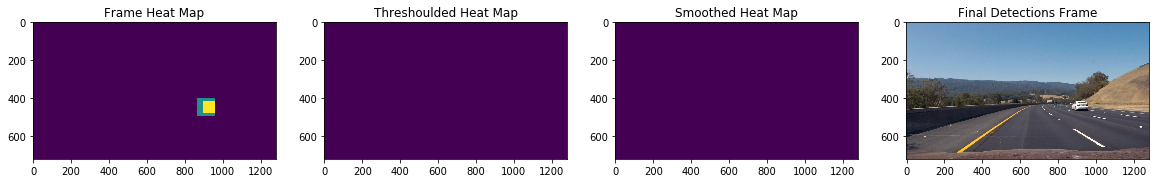

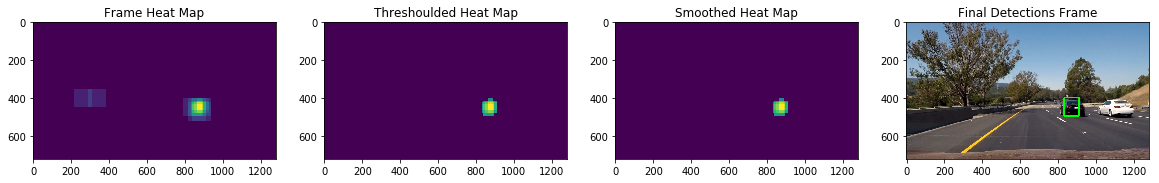

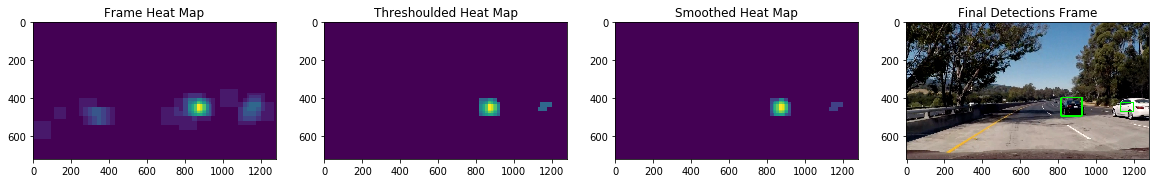

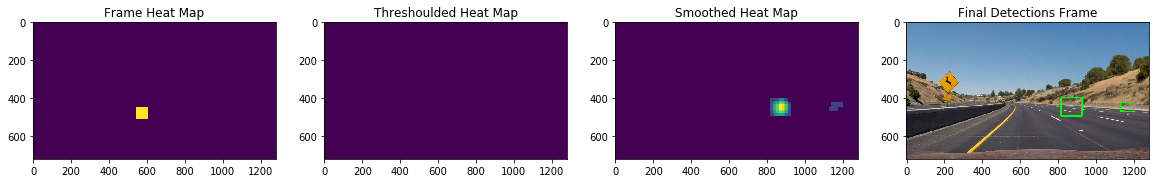

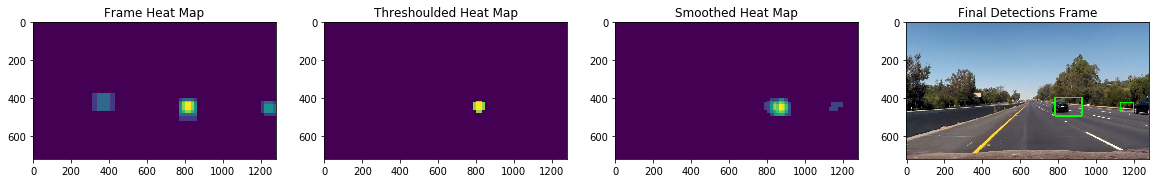

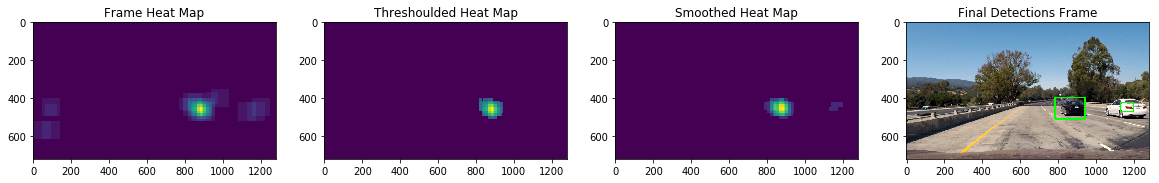

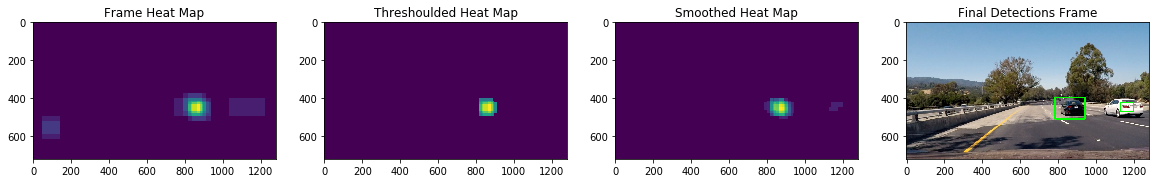

In [58]:
#### Evaluating parameters for this trial

color_space='HSV'
ystart=350
ystop=656
scales= [1, 1.5]
cell_per_block=2
spatial_size=(16,16)
hist_bins=32
pix_per_cell=8
orient=9
heatmap_thresh=4
smoothedheatmap_thresh = 3
smooth = 25
merge_thresh = 16
svc = hsv_svc_model 
X_scaler = hsv_X_scaler
vis = True
hsv_inst = HeatMap(smooth)

## 3- Detect Vehicles
## Read in test images set
test_imgs_files = glob('test_images/*.jpg')
test_imgs_list = list(map(mpimg.imread, test_imgs_files))

fig = plt.figure(figsize=(12,15))

for i in range(len(test_imgs_list)):
    image = test_imgs_list[i]   
    out_img = find_cars(image, color_space, ystart, ystop, scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, hsv_inst, smooth, vis)

### Fifth Combination

The Parameters here are as follows:
* Color Space = YUV
* Hog Orientations = 9
* Spatial Size = (16, 16)
* Cells Per Block = 2
* Pixels Per Block = 8
* Histogram Bins = 32
* Window Scale = 1, 1.5

In [59]:
#### Evaluating parameters for this trial

color_space='YUV'
spatial_size=(16, 16)
orient=9
pix_per_cell=8
cell_per_block=2
ystart = 350
ystop = 656
hist_bins=32
scale = 1.5

## 1-  Extract & Scale Training Features
veh_featVec = []
nonveh_featVec = []
veh_featVec, nonveh_featVec = train_featExtract(color_space, spatial_size, orient, pix_per_cell, cell_per_block)

scaled_feat = []
scaled_feat, yuv_X_scaler = trainfeat_scaler(veh_featVec, nonveh_featVec)

## 2- Test set split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_feat, labels, test_size=0.2, random_state=rand_state)


## 2- Classifier Training

yuv_svc_model = classifier_train(X_train, y_train, X_test, y_test)
## Save this model
with open("svc_pickle_yuv.p", "wb" ) as file:
    pickle.dump(yuv_svc_model, file)

Feature vector length: 6156
11.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


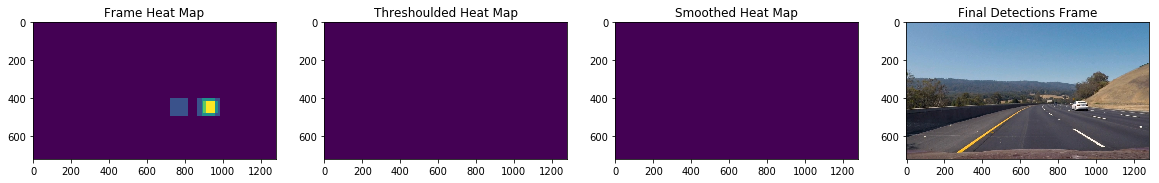

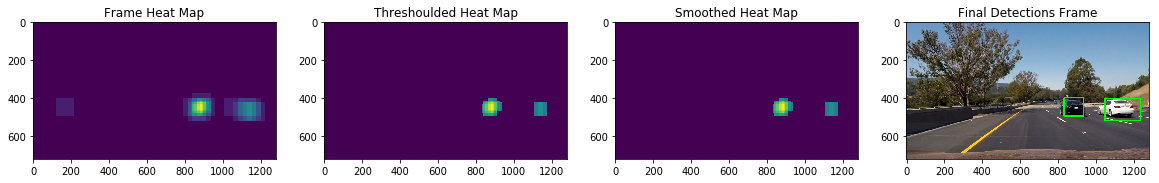

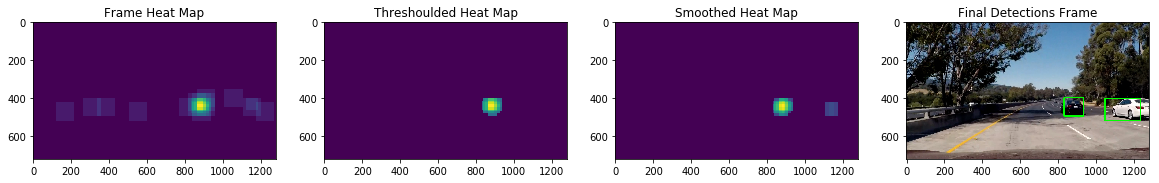

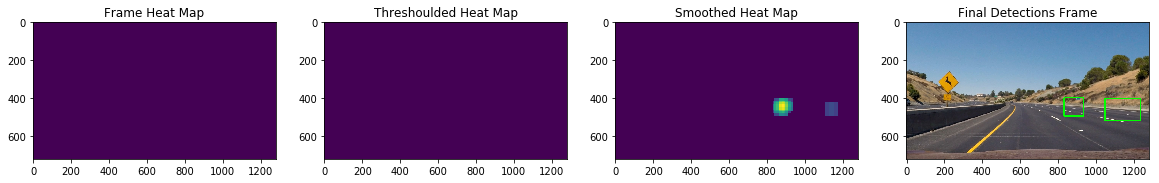

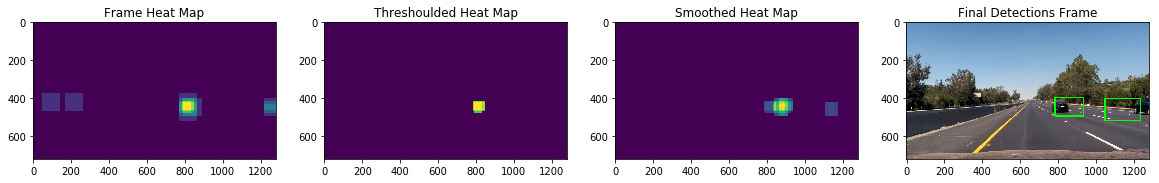

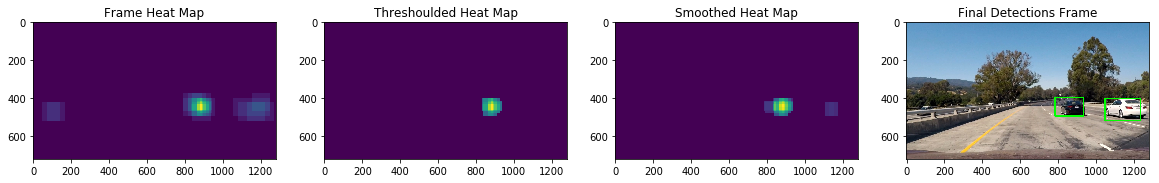

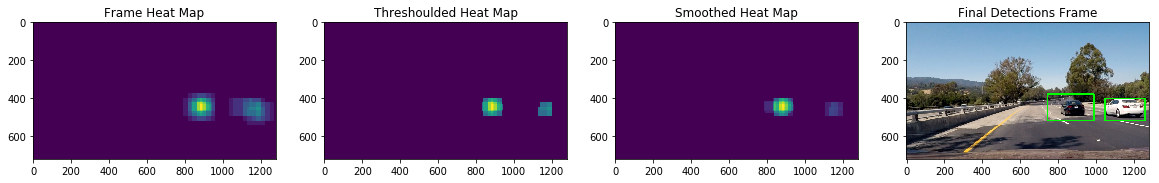

In [60]:
#### Evaluating parameters for this trial

color_space='YUV'
ystart=350
ystop=656
scales= [1, 1.5]
cell_per_block=2
spatial_size=(16,16)
hist_bins=32
pix_per_cell=8
orient=9
heatmap_thresh=4
smoothedheatmap_thresh = 3
smooth = 25
merge_thresh = 16
svc = yuv_svc_model 
X_scaler = yuv_X_scaler
vis = True
yuv_inst = HeatMap(smooth)

## 3- Detect Vehicles

## Read in test images set
test_imgs_files = glob('test_images/*.jpg')
test_imgs_list = list(map(mpimg.imread, test_imgs_files))

fig = plt.figure(figsize=(12,15))

for i in range(len(test_imgs_list)):
    image = test_imgs_list[i]   
    out_img = find_cars(image, color_space, ystart, ystop, scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, yuv_inst, smooth, vis)

### Sixth Combination

The Parameters here are as follows:
* Color Space = YCrCb
* Hog Orientations = 12
* Spatial Size = (32, 32)
* Cells Per Block = 2
* Pixels Per Block = 8
* Histogram Bins = 32
* Window Scale = 1, 1.5

In [61]:
#### Evaluating parameters for this trial

color_space='YCrCb'
spatial_size=(32, 32)
orient=12
pix_per_cell=8
cell_per_block=2
ystart = 350
ystop = 656
hist_bins=32

## 1-  Extract & Scale Training Features
veh_featVec = []
nonveh_featVec = []
veh_featVec, nonveh_featVec = train_featExtract(color_space, spatial_size, orient, pix_per_cell, cell_per_block)

scaled_feat = []
scaled_feat, YCrCb_X_scaler = trainfeat_scaler(veh_featVec, nonveh_featVec)

## 2- Test set split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_feat, labels, test_size=0.2, random_state=rand_state)


## 2- Classifier Training

YCrCb_svc_model = classifier_train(X_train, y_train, X_test, y_test)
## Save this model
with open("svc_pickle_YCrCb.p", "wb" ) as file:
    pickle.dump(YCrCb_svc_model, file)

Feature vector length: 10224
4.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


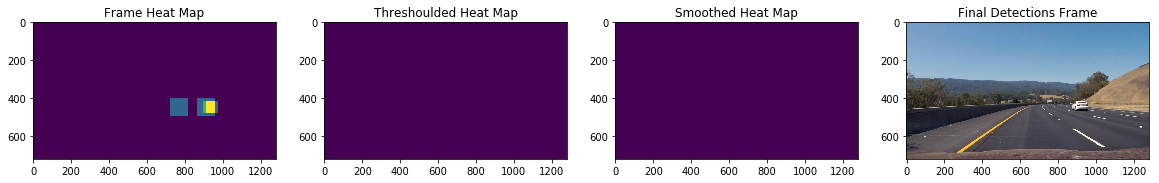

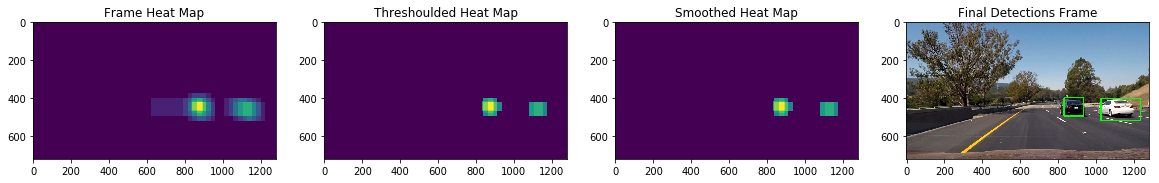

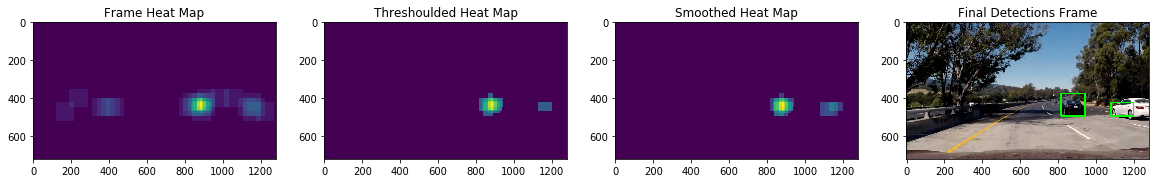

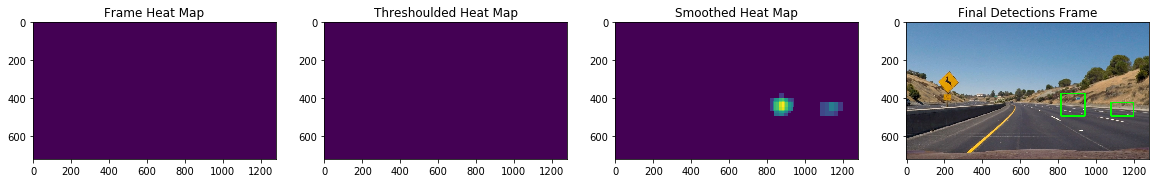

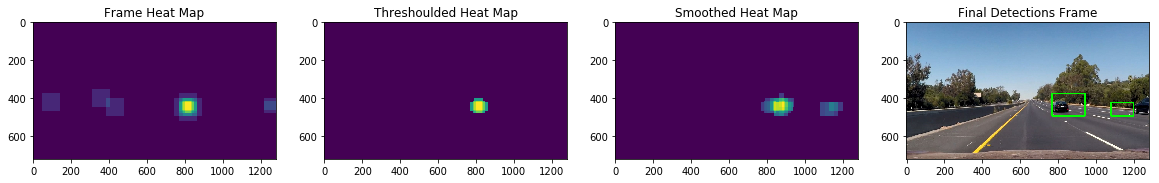

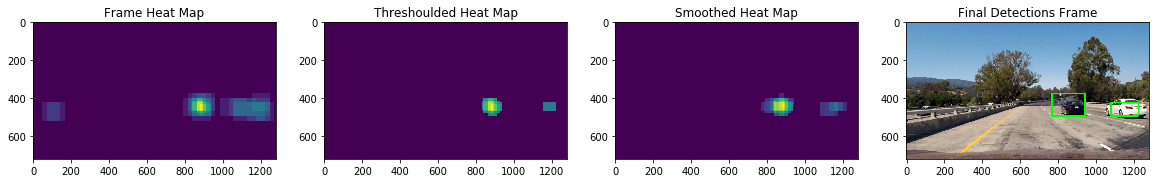

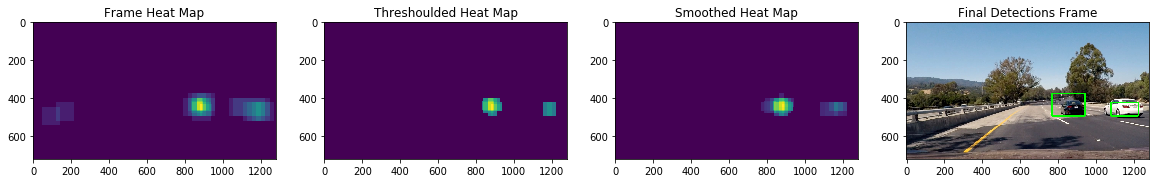

In [62]:
#### Evaluating parameters for this trial

color_space = 'YCrCb'
ystart=350
ystop=656
scales= [1, 1.5]
cell_per_block=2
spatial_size=(32,32)
hist_bins=32
pix_per_cell=8
orient=12
heatmap_thresh=4
smoothedheatmap_thresh = 3
smooth = 25
merge_thresh = 16
svc = YCrCb_svc_model 
X_scaler = YCrCb_X_scaler
vis = True
YCrCb_inst = HeatMap(smooth)
## 3- Detect Vehicles

## Read in test images set
test_imgs_files = glob('test_images/*.jpg')
test_imgs_list = list(map(mpimg.imread, test_imgs_files))

for i in range(len(test_imgs_list)):
    image = test_imgs_list[i]   
    out_img = find_cars(image, color_space, ystart, ystop, scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, YCrCb_inst, smooth, vis)

## Training Results Analysis 

* As you can see above the six features & parameters combinations used are competing strongly to win the challenge and also the
smoothing over relatively high number of frames gave us a powerful advantage of detections stability but also caused some of false positives appeared noticeablly above.

* In terms of test accuracy all of the six models did very well 98~99%.
* In terms of detection stability and false positives generation actually that led me to use multiple test clips (I've attached some of them in my submission) as it gets hard to decide upon the test images results only.

* To conclude after going through the test video clips I found that YCrCb is my best bit to go with for this problem as it showed a very stable detections with lowest false positives actually LUV also showed good results but not better than YCrCb.

**- Firstly I used YCrCb Model with: 

* ystart=350
* ystop=656
* scales= [1.5]
* cell_per_block=2
* spatial_size=(16,16)
* hist_bins=32
* pix_per_cell=8
* orient=9
* heatmap_thresh=4
* smoothedheatmap_thresh = 3
* smooth = 10
* merge_thresh = 16

**- But then in order to enhance its performance I ended up using:

* ystart=350
* ystop=656
* scales= [1, 1.5]
* cell_per_block=2
* spatial_size=(32,32)
* hist_bins=32
* pix_per_cell=8
* orient=12
* heatmap_thresh=4
* smoothedheatmap_thresh = 3
* smooth = 25
* merge_thresh = 16

* Scale of 1 helped me powerfully detecting vehicles when it get farther away.

In [64]:
## This API should perform the lane detection and the Vehicle detection & tracking using all the previous APIs.
def frame_processor(image):
    
    ystart=350
    ystop=656
    heatmap_instance.scales = [1, 1.6, 2.1]
    color_space = 'YCrCb'
    cell_per_block=2
    spatial_size=(32,32)
    hist_bins=32
    pix_per_cell=8
    orient=12
    heatmap_thresh=4
    smoothedheatmap_thresh = 3
    smooth = 25
    merge_thresh = 16
    svc = YCrCb_svc_model 
    X_scaler = YCrCb_X_scaler
    vis = False
    lane_img = lane_detect(image)
    labels = find_cars(image, color_space, ystart, ystop, heatmap_instance.scales, svc, X_scaler, orient, 
                    pix_per_cell, 
                    cell_per_block, 
                    spatial_size,
                    hist_bins, heatmap_thresh,smoothedheatmap_thresh, heatmap_instance, smooth, vis)
    out_image , smoothed_centroid = draw_labeled_bboxes(lane_img, labels, heatmap_instance)
    
    # Only for far vehicles add small search window sizes 
    if smoothed_centroid != None:
        if smoothed_centroid[1] < 550:
            heatmap_instance.scales = [0.8, 1, 1.25, 1.6, 2.1]
        else:
            heatmap_instance.scales = [1, 1.6, 2.1]
    
    return out_image

In [ ]:
## Creating line object to save the latest detections
line = Line()
# Creating heatmap object to save the latest heatmaps
smooth = 25
heatmap_instance = HeatMap(smooth)
## Specifying the output file
white_output = 'test_videos_output/project_output.mp4'
##Passing in the project video 
clip1 = VideoFileClip("project_video.mp4")
##Run the Lane Detection pipeline on each frame
white_clip = clip1.fl_image(frame_processor) 
%time white_clip.write_videofile(white_output, audio=False)